# Load and Preprocess Images 

GOALS: 
- First, you will use high-level Keras preprocessing utilities (such as tf.keras.utils.image_dataset_from_directory) and layers (such as tf.keras.layers.Rescaling) to read a directory of images on disk.
- Next, you will write your own input pipeline from scratch using tf.data.
- Finally, you will download a dataset from the large catalog available in TensorFlow Datasets

In [1]:
%pip install tensorflow-datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os 
import numpy as np 
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt 

import tensorflow as tf 
import tensorflow_datasets as tfds

/Users/harpreetsingh/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download the flowers dataset 

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True) 

In [4]:
data_dir = pathlib.Path(archive+'/flower_photos').with_suffix('')

In [5]:
data_dir

PosixPath('/Users/harpreetsingh/.keras/datasets/flower_photos.tgz/flower_photos')

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


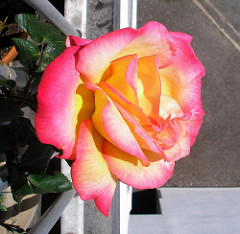

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[10]))

## Load data using Keras Util

In [8]:
batch_size = 32
img_height = 180
img_width = 180

We will use 80% of the images for training and 20% for validation

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    subset='training', 
    batch_size=batch_size, 
    image_size=(img_height, img_width), 
    seed=123
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2024-12-26 16:38:33.390158: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-26 16:38:33.390195: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-26 16:38:33.390218: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-26 16:38:33.390260: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-26 16:38:33.390279: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    subset='validation', 
    batch_size=batch_size, 
    image_size=(img_height, img_width), 
    seed=123
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Visualize the Data 

2024-12-26 16:38:33.896564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


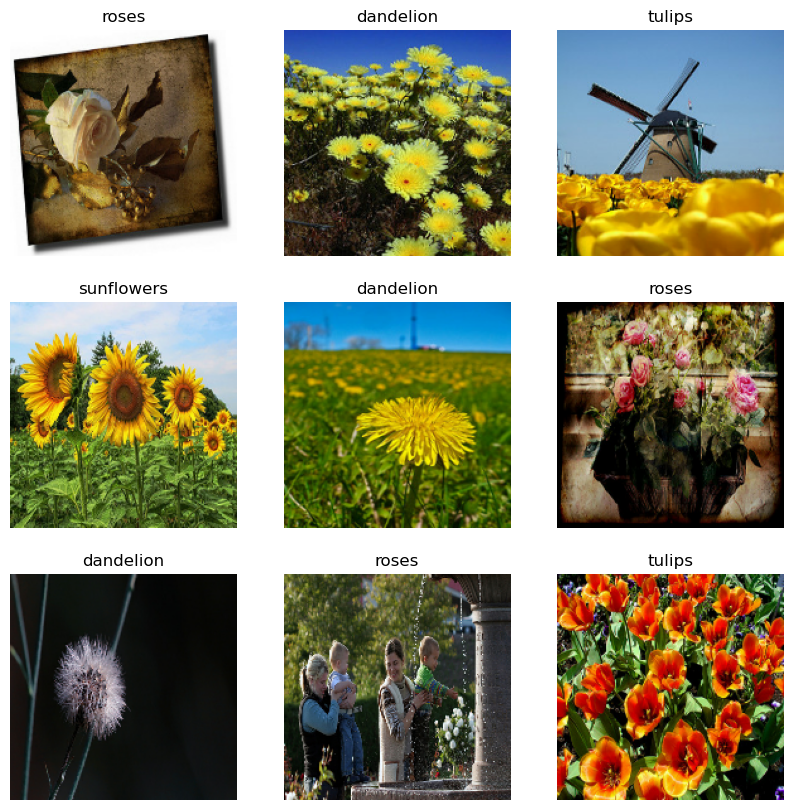

In [12]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1): 
    for i in range(9): 
        ax = plt.subplot(3, 3, i + 1) 
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## Standardize the Data 

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. 
Here, you will standardize values to be in the [0, 1] range by using `tf.keras.layers.Rescaling`

In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map or include the layer inside your model definition to simplify deployment.

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [15]:
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print([np.min(first_image), np.max(first_image)])

[0.0, 1.0]


Notice The Pixel Values are now in [0, 1]

*Note*: If you would like to scale pixel values to [-1,1] you can instead write tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Performance 

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train a Model 

In [17]:
num_classes = 5

In [18]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [21]:
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3


2024-12-26 16:38:34.953148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.3314 - loss: 1.5945 - val_accuracy: 0.5054 - val_loss: 1.2524
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.5064 - loss: 1.1885 - val_accuracy: 0.5245 - val_loss: 1.2762
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.5178 - loss: 1.2628 - val_accuracy: 0.3515 - val_loss: 1.8126


## Using tf.data for finer control

The above method `tf.keras.utils.image_dataset_from_directory` is a good way to create a dataset from a directory of images 

For Finer Control, We can write own input pipeline using `tf.Data` 

In [22]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)

In [23]:
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [24]:
for f in list_ds.take(10): 
    print(f.numpy())

b'/Users/harpreetsingh/.keras/datasets/flower_photos.tgz/flower_photos/sunflowers/9206376642_8348ba5c7a.jpg'
b'/Users/harpreetsingh/.keras/datasets/flower_photos.tgz/flower_photos/tulips/3502974120_9f1eceaf8b_n.jpg'
b'/Users/harpreetsingh/.keras/datasets/flower_photos.tgz/flower_photos/tulips/7166640338_46b15d9ec8_n.jpg'
b'/Users/harpreetsingh/.keras/datasets/flower_photos.tgz/flower_photos/sunflowers/14698136411_23bdcff7bf_n.jpg'
b'/Users/harpreetsingh/.keras/datasets/flower_photos.tgz/flower_photos/roses/1645761726_2b1be95472.jpg'
b'/Users/harpreetsingh/.keras/datasets/flower_photos.tgz/flower_photos/roses/921138131_9e1393eb2b_m.jpg'
b'/Users/harpreetsingh/.keras/datasets/flower_photos.tgz/flower_photos/tulips/17295127995_62eff434fe_n.jpg'
b'/Users/harpreetsingh/.keras/datasets/flower_photos.tgz/flower_photos/tulips/4497976955_3f8c2a21c1_m.jpg'
b'/Users/harpreetsingh/.keras/datasets/flower_photos.tgz/flower_photos/tulips/5698944116_fd35fe6bea.jpg'
b'/Users/harpreetsingh/.keras/datase

2024-12-26 16:38:56.334858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The Tree structure of the files can be used to compile a `class_names` list 

In [25]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']))

In [26]:
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

Split the Dataset into Training and Validation sets 

In [27]:
val_size = int(image_count * 0.2)
val_size

734

In [28]:
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

Print the length of the each dataset as follows 

In [29]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a function that converts a file path an (img, label) pair

In [30]:
def get_label(file_path): 
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [31]:
get_label('/Users/harpreetsingh/.keras/datasets/flower_photos.tgz/flower_photos/roses/5073473370_bdbb5a99fc.jpg')

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [32]:
def decode_img(img): 
    # Convert the compressed string to a 3D uint8 tensor 
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the Image to desired size 
    return tf.image.resize(img, [img_height, img_width])

In [33]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)

    return img, label

Create a dataset of image, label pairs 

In [34]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [35]:
for image, label in train_ds.take(3): 
    print("Image Shape", image.numpy().shape)
    print("Label", label.numpy())

Image Shape (180, 180, 3)
Label 4
Image Shape (180, 180, 3)
Label 4
Image Shape (180, 180, 3)
Label 1


2024-12-26 16:38:56.704435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Configure the dataset for Performance 

To Train a model with this dataset, you will want the data 
- To be Well shuffled
- To be Batched
- Batches to be available asap

In [36]:
def configure_for_performance(ds): 
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size=batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds 

In [37]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## Visualize the Data 

2024-12-26 16:38:57.237712: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-26 16:38:57.262964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


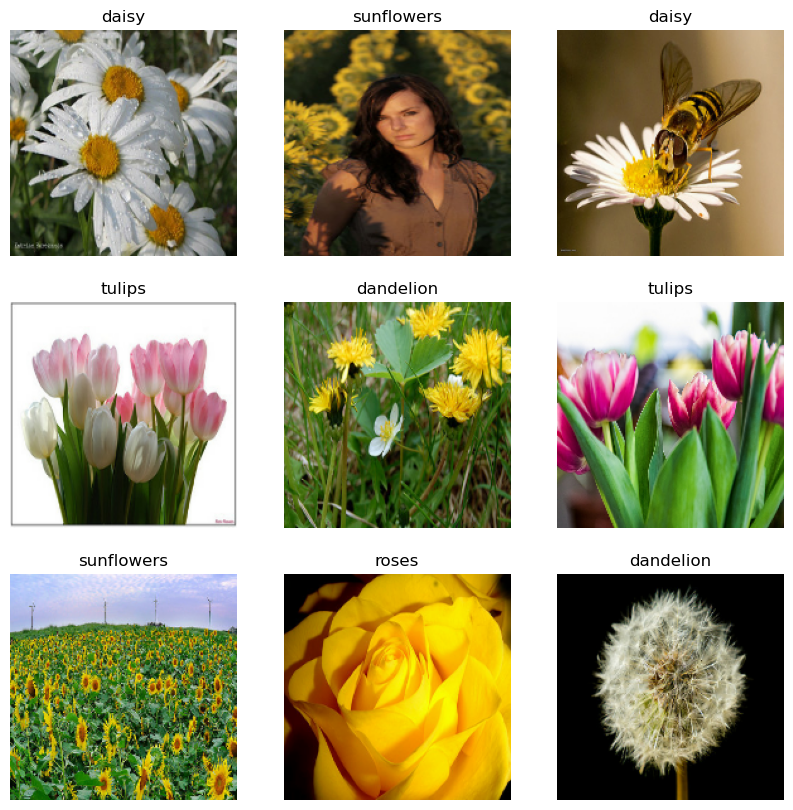

In [38]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(3): 
    for i in range(9): 
        ax = plt.subplot(3, 3, i + 1) 
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## Train the Model

In [39]:
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.4394 - loss: 1.4261 - val_accuracy: 0.4346 - val_loss: 1.2701
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.5170 - loss: 1.1592 - val_accuracy: 0.5204 - val_loss: 1.1911
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.5544 - loss: 1.1546 - val_accuracy: 0.5817 - val_loss: 1.1070
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.6512 - loss: 0.9251 - val_accuracy: 0.5681 - val_loss: 1.2408
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.6620 - loss: 1.0156 - val_accuracy: 0.4632 - val_loss: 1.3439
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.6147 - loss: 1.0270 - val_accuracy: 0.5232 - val_loss: 1.2646
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.7188 - loss: 0.7702 - val_accuracy: 0.5354 - val_loss: 1.8551
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.6725 - loss: 1.1482 - val_accuracy: 0.5777 - v